# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 1024# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["mj2"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 732 batches of 1024 samples each, total 749568 samples
Testset consists of 244 batches of 1024 samples each, total 249856 samples


20

In [12]:
X_train

array([[-0.9257721 ],
       [-0.96584487],
       [-0.80649734],
       ...,
       [-0.70836014],
       [-0.9590913 ],
       [-0.7916598 ]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['mj2'], bins = 50, range = (0, 500), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 50, range = (0, 500), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [03:40<6:23:35, 23.25s/it]


Epoch 10:

Generator training loss: -0.08794887905909879
Discriminator training loss: 0.14311513257686231

Generator validation loss: -0.21441628887760836
Discriminator validation loss: 0.1521030163056538


  2%|█▌                                                                            | 20/1000 [07:37<6:27:59, 23.76s/it]


Epoch 20:

Generator training loss: -0.39539825232302556
Discriminator training loss: 0.1525478483427092

Generator validation loss: -0.4222703899760715
Discriminator validation loss: 0.1604984734268462


  3%|██▎                                                                           | 30/1000 [11:35<6:22:45, 23.68s/it]


Epoch 30:

Generator training loss: -0.21957524878079773
Discriminator training loss: 0.1379074636297148

Generator validation loss: -0.32998858404452686
Discriminator validation loss: 0.16080968301804338


  4%|███                                                                           | 40/1000 [15:31<6:15:49, 23.49s/it]


Epoch 40:

Generator training loss: -0.03703884609091945
Discriminator training loss: 0.10648291753554115

Generator validation loss: -0.3086280822753906
Discriminator validation loss: 0.1629065741769603


  5%|███▉                                                                          | 50/1000 [19:28<6:16:13, 23.76s/it]


Epoch 50:

Generator training loss: 0.3403397815230766
Discriminator training loss: 0.044990472799635244

Generator validation loss: -0.2561550438404083
Discriminator validation loss: 0.16521996045943166


  6%|████▋                                                                         | 60/1000 [23:24<6:10:15, 23.63s/it]


Epoch 60:

Generator training loss: 1.120696489358209
Discriminator training loss: -0.012333028499477998

Generator validation loss: 0.48948108099523135
Discriminator validation loss: 0.01111607379956337


  7%|█████▍                                                                        | 70/1000 [27:22<6:06:58, 23.68s/it]


Epoch 70:

Generator training loss: 1.1169289164855831
Discriminator training loss: -0.006977590867094367

Generator validation loss: 0.6488206743216905
Discriminator validation loss: -0.012815098857438405


  8%|██████▏                                                                       | 80/1000 [31:20<6:04:01, 23.74s/it]


Epoch 80:

Generator training loss: 0.9690200956792779
Discriminator training loss: -0.006072239561305894

Generator validation loss: 0.47178850970307334
Discriminator validation loss: -0.009531346867557569


  9%|███████                                                                       | 90/1000 [35:17<6:00:09, 23.75s/it]


Epoch 90:

Generator training loss: 0.902606886511292
Discriminator training loss: -0.006204378812506925

Generator validation loss: 0.4073810837552196
Discriminator validation loss: 0.0018901855362289143


 10%|███████▋                                                                      | 99/1000 [38:52<5:59:34, 23.94s/it]


Epoch 100:

Generator training loss: 0.8016676637318616
Discriminator training loss: -0.008627783441551514

Generator validation loss: 0.3046808189055959
Discriminator validation loss: 0.0038430015024534412

Epoch 100:


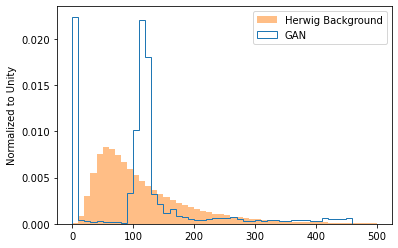

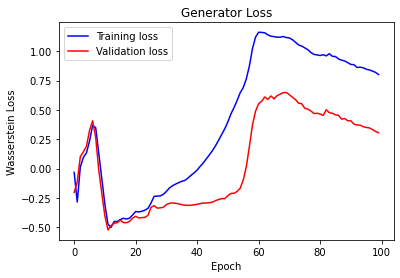

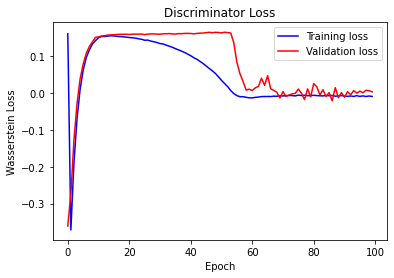

 11%|████████▍                                                                    | 110/1000 [43:13<5:50:58, 23.66s/it]


Epoch 110:

Generator training loss: 0.5636681349225383
Discriminator training loss: -0.013671416095922359

Generator validation loss: 0.07280830776349442
Discriminator validation loss: 0.005138409844996621


 12%|█████████▏                                                                   | 120/1000 [47:08<5:45:19, 23.54s/it]


Epoch 120:

Generator training loss: 0.4380671857077567
Discriminator training loss: -0.015683969179638456

Generator validation loss: -0.049688790527889964
Discriminator validation loss: 0.0041318083568199415


 13%|██████████                                                                   | 130/1000 [51:04<5:41:48, 23.57s/it]


Epoch 130:

Generator training loss: 0.12361023920051285
Discriminator training loss: 0.013620446038094883

Generator validation loss: -0.38499136427875424
Discriminator validation loss: 0.032775151596994324


 14%|██████████▊                                                                  | 140/1000 [55:01<5:40:20, 23.75s/it]


Epoch 140:

Generator training loss: -0.10946209544997887
Discriminator training loss: -0.004580045678201594

Generator validation loss: -0.6238921003752067
Discriminator validation loss: 0.04591843659322056


 15%|███████████▌                                                                 | 150/1000 [58:57<5:34:30, 23.61s/it]


Epoch 150:

Generator training loss: -0.23415428651445877
Discriminator training loss: 0.032782690305945036

Generator validation loss: -0.7372897089016243
Discriminator validation loss: 0.09363945642606447


 16%|████████████                                                               | 160/1000 [1:02:54<5:30:59, 23.64s/it]


Epoch 160:

Generator training loss: -0.2471771017734796
Discriminator training loss: 0.009672091362587256

Generator validation loss: -0.7825894590284004
Discriminator validation loss: 0.016227180739391413


 17%|████████████▊                                                              | 170/1000 [1:06:50<5:27:05, 23.65s/it]


Epoch 170:

Generator training loss: -0.24701931183048284
Discriminator training loss: 0.011670501718886119

Generator validation loss: -0.8068547737402995
Discriminator validation loss: 0.015881554092391257


 18%|█████████████▌                                                             | 180/1000 [1:10:48<5:23:39, 23.68s/it]


Epoch 180:

Generator training loss: -0.29735832549428026
Discriminator training loss: 0.009016461856955458

Generator validation loss: -0.8924723179613958
Discriminator validation loss: 0.05416492599474847


 19%|██████████████▎                                                            | 190/1000 [1:14:45<5:21:19, 23.80s/it]


Epoch 190:

Generator training loss: -0.2963794766635191
Discriminator training loss: -0.006206197102162642

Generator validation loss: -0.8946018773512762
Discriminator validation loss: 0.03152941955925256


 20%|██████████████▉                                                            | 199/1000 [1:18:19<5:16:17, 23.69s/it]


Epoch 200:

Generator training loss: -0.3610833592997874
Discriminator training loss: 0.004213284080696376

Generator validation loss: -0.9244505174335886
Discriminator validation loss: -0.004742048911104396

Epoch 200:


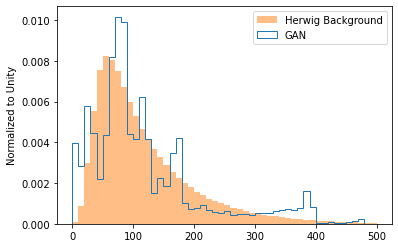

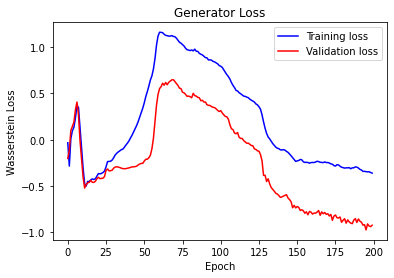

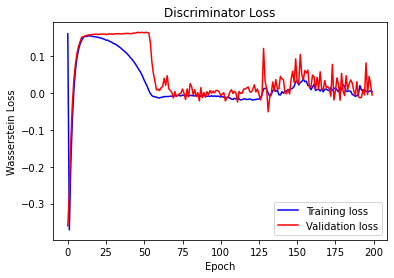

 21%|███████████████▊                                                           | 210/1000 [1:22:39<5:10:40, 23.60s/it]


Epoch 210:

Generator training loss: -0.39733037641628194
Discriminator training loss: -0.0006104957987471374

Generator validation loss: -1.0238881941701545
Discriminator validation loss: 0.05556990551288988


 22%|████████████████▌                                                          | 220/1000 [1:26:36<5:08:32, 23.73s/it]


Epoch 220:

Generator training loss: -0.5201087980811062
Discriminator training loss: 0.005266662483759841

Generator validation loss: -1.1156359549428596
Discriminator validation loss: -0.00820465760864222


 23%|█████████████████▎                                                         | 230/1000 [1:30:33<5:03:33, 23.65s/it]


Epoch 230:

Generator training loss: -0.6187608310026549
Discriminator training loss: 0.009484726379769746

Generator validation loss: -1.190000209163447
Discriminator validation loss: -0.007549117952890572


 24%|██████████████████                                                         | 240/1000 [1:34:29<4:59:29, 23.64s/it]


Epoch 240:

Generator training loss: -0.8111634271555259
Discriminator training loss: 0.0037933555677217624

Generator validation loss: -1.3642542645579478
Discriminator validation loss: -0.08648663627930352


 25%|██████████████████▊                                                        | 250/1000 [1:38:25<4:54:54, 23.59s/it]


Epoch 250:

Generator training loss: -0.9106570668722112
Discriminator training loss: 0.00029811921793255157

Generator validation loss: -1.5157147948859169
Discriminator validation loss: -0.03326986895752002


 26%|███████████████████▌                                                       | 260/1000 [1:42:22<4:50:38, 23.57s/it]


Epoch 260:

Generator training loss: -1.079311865030742
Discriminator training loss: 0.0033037529300982684

Generator validation loss: -1.792781353485389
Discriminator validation loss: 0.012776939188593952


 27%|████████████████████▎                                                      | 270/1000 [1:46:18<4:47:35, 23.64s/it]


Epoch 270:

Generator training loss: -1.0422954463242182
Discriminator training loss: -0.00026119764258368614

Generator validation loss: -1.698374478543391
Discriminator validation loss: -0.009164138671308808


 28%|█████████████████████                                                      | 280/1000 [1:50:15<4:44:21, 23.70s/it]


Epoch 280:

Generator training loss: -1.1218339699050768
Discriminator training loss: 0.0010079333980515192

Generator validation loss: -1.8329948553296387
Discriminator validation loss: 0.035522451162429865


 29%|█████████████████████▊                                                     | 290/1000 [1:54:11<4:39:53, 23.65s/it]


Epoch 290:

Generator training loss: -1.1222496285953156
Discriminator training loss: 0.00021592079670729923

Generator validation loss: -1.8162561508475756
Discriminator validation loss: 0.021892321414360014


 30%|██████████████████████▍                                                    | 299/1000 [1:57:45<4:37:52, 23.78s/it]


Epoch 300:

Generator training loss: -1.1350343287642537
Discriminator training loss: 0.0008343755071740806

Generator validation loss: -1.8029560827818074
Discriminator validation loss: 0.0002360166517973994

Epoch 300:


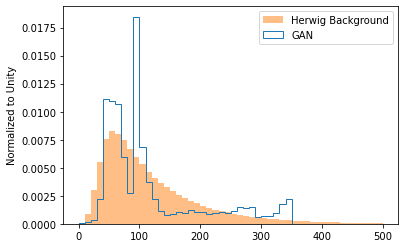

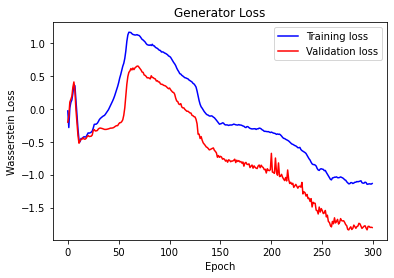

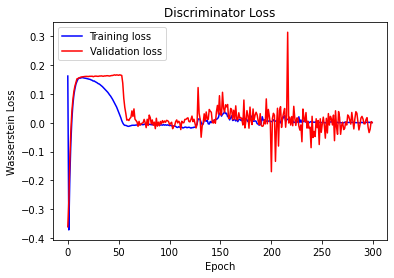

 31%|███████████████████████▎                                                   | 310/1000 [2:02:05<4:31:23, 23.60s/it]


Epoch 310:

Generator training loss: -1.066399772636226
Discriminator training loss: 0.0014800056818051073

Generator validation loss: -1.7381684477211998
Discriminator validation loss: 0.006243974001992057


 32%|████████████████████████                                                   | 320/1000 [2:06:03<4:30:20, 23.85s/it]


Epoch 320:

Generator training loss: -1.1042799928474947
Discriminator training loss: 0.0005884279661233469

Generator validation loss: -1.7863674549782862
Discriminator validation loss: 0.013764707350599596


 33%|████████████████████████▊                                                  | 330/1000 [2:10:00<4:25:03, 23.74s/it]


Epoch 330:

Generator training loss: -1.1593682702447548
Discriminator training loss: -0.0006639971166358188

Generator validation loss: -1.813807906674557
Discriminator validation loss: 0.0005747862247278777


 34%|█████████████████████████▌                                                 | 340/1000 [2:13:57<4:20:22, 23.67s/it]


Epoch 340:

Generator training loss: -1.2665393749872844
Discriminator training loss: 0.0015186625176144839

Generator validation loss: -1.959567777446059
Discriminator validation loss: -0.003831347901633889


 35%|██████████████████████████▎                                                | 350/1000 [2:17:53<4:16:57, 23.72s/it]


Epoch 350:

Generator training loss: -1.1999320194043748
Discriminator training loss: 5.045731445211285e-05

Generator validation loss: -1.894265712284651
Discriminator validation loss: 0.02726584502694304


 36%|███████████████████████████                                                | 360/1000 [2:21:49<4:11:08, 23.55s/it]


Epoch 360:

Generator training loss: -1.2425304659403087
Discriminator training loss: 0.0008167611270163847

Generator validation loss: -1.9399491416626289
Discriminator validation loss: 0.002569890110221497


 37%|███████████████████████████▊                                               | 370/1000 [2:25:45<4:07:36, 23.58s/it]


Epoch 370:

Generator training loss: -1.2401457112995002
Discriminator training loss: 0.0007649432739203629

Generator validation loss: -1.9098387937076757
Discriminator validation loss: -0.013070006928545973


 38%|████████████████████████████▌                                              | 380/1000 [2:29:42<4:04:12, 23.63s/it]


Epoch 380:

Generator training loss: -1.2614181614964386
Discriminator training loss: 0.00192701500665882

Generator validation loss: -1.9300679896698623
Discriminator validation loss: -0.04626162193685037


 39%|█████████████████████████████▎                                             | 390/1000 [2:33:37<3:59:06, 23.52s/it]


Epoch 390:

Generator training loss: -1.234537914151051
Discriminator training loss: 0.0007315940775911233

Generator validation loss: -1.9433175906783244
Discriminator validation loss: 0.01472079295108713


 40%|█████████████████████████████▉                                             | 399/1000 [2:37:10<3:57:31, 23.71s/it]


Epoch 400:

Generator training loss: -1.1625780881754035
Discriminator training loss: 0.0016307680480396234

Generator validation loss: -1.8690399195327134
Discriminator validation loss: 0.011732297505301683

Epoch 400:


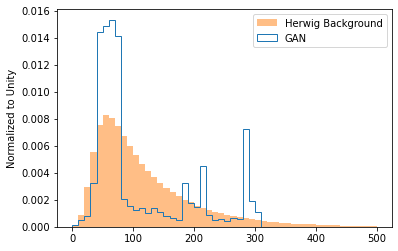

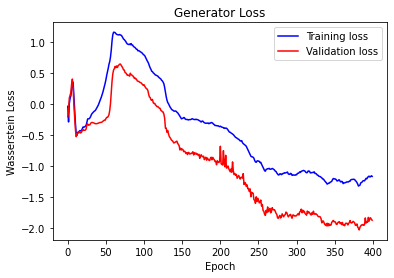

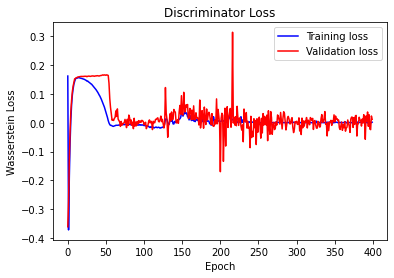

 41%|██████████████████████████████▋                                            | 410/1000 [2:41:29<3:51:27, 23.54s/it]


Epoch 410:

Generator training loss: -1.1773014902417125
Discriminator training loss: -0.0005273639427450987

Generator validation loss: -1.8303234078845039
Discriminator validation loss: -0.03069934639774385


 42%|███████████████████████████████▌                                           | 420/1000 [2:45:24<3:47:40, 23.55s/it]


Epoch 420:

Generator training loss: -1.2472806341661131
Discriminator training loss: 0.0006736190402904962

Generator validation loss: -1.9237835588025265
Discriminator validation loss: 0.01980553361678832


 43%|████████████████████████████████▎                                          | 430/1000 [2:49:20<3:43:26, 23.52s/it]


Epoch 430:

Generator training loss: -1.1903348670956866
Discriminator training loss: -0.0002846604647240751

Generator validation loss: -1.8263410808610134
Discriminator validation loss: -0.03317649629669356


 44%|█████████████████████████████████                                          | 440/1000 [2:53:18<3:41:37, 23.75s/it]


Epoch 440:

Generator training loss: -1.2688064874847078
Discriminator training loss: 0.0008086652818419084

Generator validation loss: -1.924494329534593
Discriminator validation loss: -0.009944502551296282


 45%|█████████████████████████████████▊                                         | 450/1000 [2:57:14<3:36:58, 23.67s/it]


Epoch 450:

Generator training loss: -1.244204796239978
Discriminator training loss: -0.0012041202969580336

Generator validation loss: -1.909894922717673
Discriminator validation loss: -0.015291676026402561


 46%|██████████████████████████████████▌                                        | 460/1000 [3:01:10<3:31:41, 23.52s/it]


Epoch 460:

Generator training loss: -1.2608964154954816
Discriminator training loss: -0.00041757822770899217

Generator validation loss: -1.8903673784654649
Discriminator validation loss: -0.041997475251860795


 47%|███████████████████████████████████▎                                       | 470/1000 [3:05:05<3:27:55, 23.54s/it]


Epoch 470:

Generator training loss: -1.3435303318044527
Discriminator training loss: 0.00024956175911727553

Generator validation loss: -1.9867586122184504
Discriminator validation loss: -0.03812073062357233


 48%|████████████████████████████████████                                       | 480/1000 [3:09:01<3:23:57, 23.53s/it]


Epoch 480:

Generator training loss: -1.4886510883524118
Discriminator training loss: 0.00022642199887269154

Generator validation loss: -2.1210021503636094
Discriminator validation loss: -0.0031994823249511146


 49%|████████████████████████████████████▊                                      | 490/1000 [3:12:57<3:21:08, 23.66s/it]


Epoch 490:

Generator training loss: -1.563345703108063
Discriminator training loss: 4.3564299433013424e-05

Generator validation loss: -2.167763621103568
Discriminator validation loss: -0.014080719414957204


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:16:30<3:16:40, 23.55s/it]


Epoch 500:

Generator training loss: -1.6358321128321476
Discriminator training loss: 0.001899122678536554

Generator validation loss: -2.2788523230396334
Discriminator validation loss: -0.008834831308183206

Epoch 500:


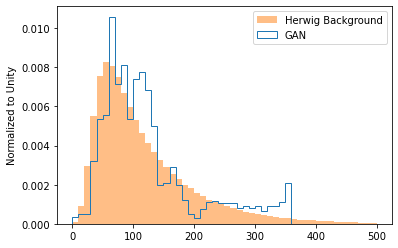

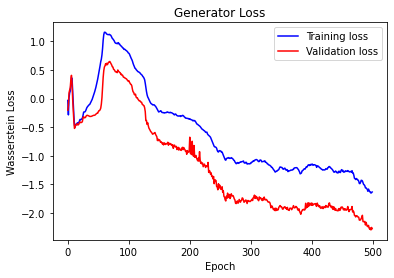

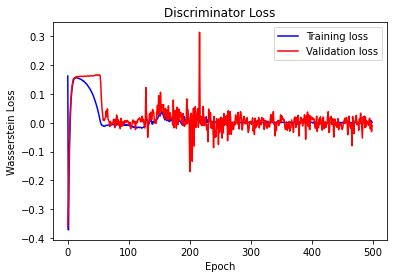

 51%|██████████████████████████████████████▎                                    | 510/1000 [3:20:49<3:12:15, 23.54s/it]


Epoch 510:

Generator training loss: -1.6541092640063801
Discriminator training loss: 0.0038012447234582218

Generator validation loss: -2.3363949148381344
Discriminator validation loss: 0.015074414410532956


 52%|███████████████████████████████████████                                    | 520/1000 [3:24:45<3:09:08, 23.64s/it]


Epoch 520:

Generator training loss: -1.7422493658756297
Discriminator training loss: 0.0011501086618066394

Generator validation loss: -2.3967593654257353
Discriminator validation loss: -0.026699725418259986


 53%|███████████████████████████████████████▊                                   | 530/1000 [3:28:42<3:05:39, 23.70s/it]


Epoch 530:

Generator training loss: -1.9149575665023157
Discriminator training loss: 0.0023126584361585637

Generator validation loss: -2.5581920772302347
Discriminator validation loss: 0.01063733651495031


 54%|████████████████████████████████████████▌                                  | 540/1000 [3:32:39<3:02:07, 23.76s/it]


Epoch 540:

Generator training loss: -1.9314722540925762
Discriminator training loss: 0.0006848601507839991

Generator validation loss: -2.5819235033676273
Discriminator validation loss: 0.006732068906054993


 55%|█████████████████████████████████████████▎                                 | 550/1000 [3:36:35<2:58:04, 23.74s/it]


Epoch 550:

Generator training loss: -2.0120875942902487
Discriminator training loss: -0.0012047566309943971

Generator validation loss: -2.620939003639534
Discriminator validation loss: -0.041421933855372864


 56%|██████████████████████████████████████████                                 | 560/1000 [3:40:31<2:53:14, 23.62s/it]


Epoch 560:

Generator training loss: -2.0527502448180988
Discriminator training loss: -0.0004485041136351972

Generator validation loss: -2.7262316316854758
Discriminator validation loss: 0.0006245665362868869


 57%|██████████████████████████████████████████▋                                | 570/1000 [3:44:28<2:49:03, 23.59s/it]


Epoch 570:

Generator training loss: -2.120618340096187
Discriminator training loss: 0.0010309438050191474

Generator validation loss: -2.770056007338352
Discriminator validation loss: 0.008889191609818763


 58%|███████████████████████████████████████████▌                               | 580/1000 [3:48:25<2:46:19, 23.76s/it]


Epoch 580:

Generator training loss: -2.0870836079120636
Discriminator training loss: -0.0007874702691869125

Generator validation loss: -2.7606011306653255
Discriminator validation loss: -0.013912215110842048


 59%|████████████████████████████████████████████▎                              | 590/1000 [3:52:22<2:41:22, 23.62s/it]


Epoch 590:

Generator training loss: -2.1809292458445646
Discriminator training loss: 0.0013982175620424

Generator validation loss: -2.8681972632642654
Discriminator validation loss: -0.008761685016370244


 60%|████████████████████████████████████████████▉                              | 599/1000 [3:55:55<2:38:12, 23.67s/it]


Epoch 600:

Generator training loss: -2.330165296955838
Discriminator training loss: 0.0030002596689435628

Generator validation loss: -3.0188963501179806
Discriminator validation loss: 0.01400921325580757

Epoch 600:


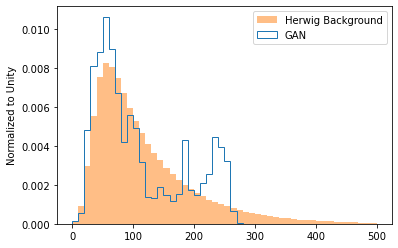

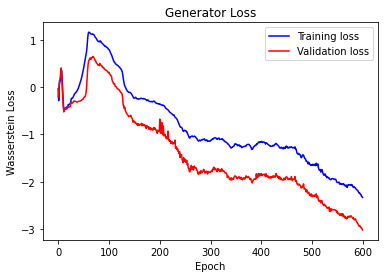

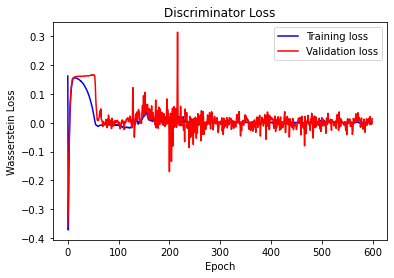

 61%|█████████████████████████████████████████████▊                             | 610/1000 [4:00:15<2:33:41, 23.64s/it]


Epoch 610:

Generator training loss: -2.4338362946536374
Discriminator training loss: 0.0022708060989296555

Generator validation loss: -3.113602696872148
Discriminator validation loss: 0.0012577042358524985


 61%|█████████████████████████████████████████████▊                             | 611/1000 [4:00:38<2:33:25, 23.66s/it]

In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z